# Get sen2 DF

In [156]:
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import glob
import time
from rasterio.merge import merge
from rasterio.plot import show
import rasterio.features
import rasterio.warp
from geojson import Point, Feature, FeatureCollection, dump
import shapely.wkt
import matplotlib.pyplot as plt

In [2]:
root_dir = !pwd
root_dir = str(root_dir[0])
folder = "/sen2/merged_reprojected"
files_folder = root_dir + folder


In [3]:

# define search criteria
search_criteria = "*.tif"
search_term = os.path.join(files_folder, search_criteria)
# perform search


In [4]:
# create DF and uniwe
files = glob.glob(search_term)
dates = []
tiles = []
for i in files:
    dates.append(i[78:86])
    tiles.append(i[102:108])
df_sen2 = pd.DataFrame(np.column_stack([files, dates,tiles]),columns=["files","dates","tiles"])
unique_dates = pd.unique(df_sen2["dates"])

In [5]:
df_sen2

,files,dates,tiles
0,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180419,T30UXU
1,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180709,T30TVT
2,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180709,T30UVV
3,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180623,T30UXU
4,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180803,T30TVT
...,...,...,...
121,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180902,T30UUU
122,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180927,T30TWT
123,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180420,T30UVV
124,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180714,T30UWU


In [6]:
names = []
geoms = []
out_fp = root_dir + "footprints"


# Extract Footprints
counter = 0
for i in df_sen2["files"]:
    # def counter cond
    counter = counter+1
    if counter%1==0:
        perc = 100 * float(counter)/float(len(df_sen2["files"]))
        print(str(int(perc))+"%","       ",end="\r")
    
    
    file_name = i[i.rfind("/")+1:i.rfind(".")]
    #print(file_name)
    out_name = out_fp + file_name+".GeoJSON"
    #print(out_name)
    
    with rasterio.open(i) as dataset:

        # Read the dataset's valid data mask as a ndarray.
        mask = dataset.dataset_mask()

        # Extract feature shapes and values from the array.
        for geom, val in rasterio.features.shapes(
                mask, transform=dataset.transform):

            # Transform shapes from the dataset's own coordinate
            # reference system to CRS84 (EPSG:4326).
            #geom = rasterio.warp.transform_geom(
            #    dataset.crs, 'EPSG:4326', geom, precision=6)

            # Print GeoJSON shapes to stdout.
            n = out_name[out_name.rfind("/")+1:out_name.rfind(".")] + ".jp2"
            n = n.replace("footprints","")
            names.append(n)
            geoms.append(geom)
print(str(100)+"%","       ",end="\r")

In [7]:
# Modify WKT to be able to pass into GDF
wkt_geoms = []
for v,i in enumerate(geoms):
    coordinates = i["coordinates"]
    wkt_str = "POLYGON (("
    for coor in coordinates:
        for x in coor:
            wkt_str=wkt_str+""
            x_1 = str(x).replace(",","")
            x_1 = x_1.replace("(","")
            x_1 = x_1.replace(")","")
            #x_1 = x_1.replace(".0","")
            wkt_str = wkt_str+x_1+","
        wkt_str = wkt_str[:wkt_str.rfind(",")] + wkt_str[wkt_str.rfind(",")+1:]
            
    wkt_str = wkt_str.replace("[","")
    wkt_str = wkt_str.replace("]","")
    wkt_str = wkt_str+"))"
    #print(wkt_str)
    wkt_geoms.append(shapely.wkt.loads(wkt_str))

df_sen2["geom"] = wkt_geoms
gdf_sen2 = gpd.GeoDataFrame(df_sen2, geometry=df_sen2.geom)
gdf_sen2.set_crs(epsg=2154)

,files,dates,tiles,geom,geometry
0,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180419,T30UXU,"POLYGON ((350647.0106609548 6859450.010744817,...","POLYGON ((350647.011 6859450.011, 350647.011 6..."
1,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180709,T30TVT,"POLYGON ((143692.6836516875 6774980.536423556,...","POLYGON ((143692.684 6774980.536, 143692.684 6..."
2,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180709,T30UVV,"POLYGON ((158798.9263208066 6974419.573005313,...","POLYGON ((158798.926 6974419.573, 158798.926 6..."
3,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180623,T30UXU,"POLYGON ((350647.0106609548 6859450.010744817,...","POLYGON ((350647.011 6859450.011, 350647.011 6..."
4,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180803,T30TVT,"POLYGON ((143692.6836516875 6774980.536423556,...","POLYGON ((143692.684 6774980.536, 143692.684 6..."
...,...,...,...,...,...
121,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180902,T30UUU,"POLYGON ((51639.68855335622 6882132.811613104,...","POLYGON ((51639.689 6882132.812, 51639.689 676..."
122,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180927,T30TWT,"POLYGON ((243367.3657216941 6767408.600556872,...","POLYGON ((243367.366 6767408.601, 243367.366 6..."
123,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180420,T30UVV,"POLYGON ((158798.9263208066 6974419.573005313,...","POLYGON ((158798.926 6974419.573, 158798.926 6..."
124,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180714,T30UWU,"POLYGON ((250952.2064251588 6867075.183695725,...","POLYGON ((250952.206 6867075.184, 250952.206 6..."


<AxesSubplot:>

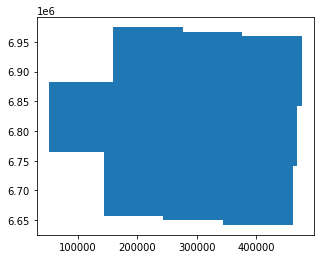

In [8]:
gdf_sen2.plot()

# Get Spot6 DF
## Get Spot6 Footprints

In [9]:
# define inputs
sensor = "spot6"
root_dir = "/home/simon/CDE_UBS/thesis/data_collection/"
out_fp = root_dir + "footprints"
path = root_dir + sensor



# define search criteria automatically based on sensor
if sensor == "spot6":
    search_criteria = "*.jp2"
if sensor == "sen2":
    search_criteria = "*.tif"
search_term = os.path.join(path, search_criteria)
# perform search
files = glob.glob(search_term)


In [10]:
names = []
geoms = []

# Extract Footprints
counter = 0
for i in files:
    # def counter cond
    counter = counter+1
    if counter%1==0:
        perc = 100 * float(counter)/float(len(files))
        print(str(int(perc))+"%","       ",end="\r")
    
    
    file_name = i[i.rfind("/")+1:i.rfind(".")]
    #print(file_name)
    out_name = out_fp + file_name+".GeoJSON"
    #print(out_name)
    
    with rasterio.open(i) as dataset:

        # Read the dataset's valid data mask as a ndarray.
        mask = dataset.dataset_mask()

        # Extract feature shapes and values from the array.
        for geom, val in rasterio.features.shapes(
                mask, transform=dataset.transform):

            # Transform shapes from the dataset's own coordinate
            # reference system to CRS84 (EPSG:4326).
            #geom = rasterio.warp.transform_geom(
            #    dataset.crs, 'EPSG:4326', geom, precision=6)

            # Print GeoJSON shapes to stdout.
            n = out_name[out_name.rfind("/")+1:out_name.rfind(".")] + ".jp2"
            n = n.replace("footprints","")
            names.append(n)
            geoms.append(geom)
print(str(100)+"%","       ",end="\r")

In [11]:
# Modify WKT to be able to pass into GDF
wkt_geoms = []
for v,i in enumerate(geoms):
    coordinates = i["coordinates"]
    wkt_str = "POLYGON (("
    for coor in coordinates:
        for x in coor:
            wkt_str=wkt_str+""
            x_1 = str(x).replace(",","")
            x_1 = x_1.replace("(","")
            x_1 = x_1.replace(")","")
            #x_1 = x_1.replace(".0","")
            wkt_str = wkt_str+x_1+","
            #print(wkt_str)
        wkt_str = wkt_str[:wkt_str.rfind(",")] + wkt_str[wkt_str.rfind(",")+1:]
            
    wkt_str = wkt_str.replace("[","")
    wkt_str = wkt_str.replace("]","")
    wkt_str = wkt_str+"))"
    #print(wkt_str)
    wkt_geoms.append(shapely.wkt.loads(wkt_str))

df_spot6 = pd.DataFrame()
df_spot6["name"] = names
df_spot6["geom"] = wkt_geoms
gdf_spot6 = gpd.GeoDataFrame(df_spot6, geometry=df_spot6.geom)
gdf_spot6.set_crs(epsg=2154)

,name,geom,geometry
0,ORT_2018_0159_6792_LA93_8Bits.jp2,"POLYGON ((159000 6792000, 159000 6789000, 1620...","POLYGON ((159000.000 6792000.000, 159000.000 6..."
1,ORT_2018_0147_6846_LA93_8Bits.jp2,"POLYGON ((147000 6846000, 147000 6843000, 1500...","POLYGON ((147000.000 6846000.000, 147000.000 6..."
2,ORT_2018_0279_6834_LA93_8Bits.jp2,"POLYGON ((279000 6834000, 279000 6831000, 2820...","POLYGON ((279000.000 6834000.000, 279000.000 6..."
3,ORT_2018_0342_6771_LA93_8Bits.jp2,"POLYGON ((342000 6771000, 342000 6768000, 3450...","POLYGON ((342000.000 6771000.000, 342000.000 6..."
4,ORT_2018_0255_6843_LA93_8Bits.jp2,"POLYGON ((255000 6843000, 255000 6840000, 2580...","POLYGON ((255000.000 6843000.000, 255000.000 6..."
...,...,...,...
3347,ORT_2018_0219_6849_LA93_8Bits.jp2,"POLYGON ((219000 6849000, 219000 6846000, 2220...","POLYGON ((219000.000 6849000.000, 219000.000 6..."
3348,ORT_2018_0363_6780_LA93_8Bits.jp2,"POLYGON ((363000 6780000, 363000 6777000, 3660...","POLYGON ((363000.000 6780000.000, 363000.000 6..."
3349,ORT_2018_0312_6735_LA93_8Bits.jp2,"POLYGON ((312000 6735000, 312000 6732000, 3150...","POLYGON ((312000.000 6735000.000, 312000.000 6..."
3350,ORT_2018_0288_6801_LA93_8Bits.jp2,"POLYGON ((288000 6801000, 288000 6798000, 2910...","POLYGON ((288000.000 6801000.000, 288000.000 6..."


<AxesSubplot:>

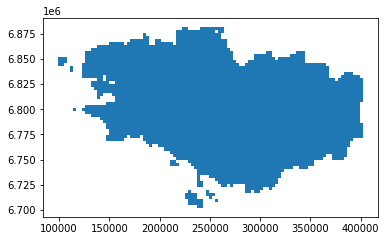

In [12]:
gdf_spot6.plot()

## Get Centroids

In [13]:
def get_centroid(gdf):
    a = gpd.GeoSeries(gdf.centroid)
    return(list(a))

In [14]:
gdf_spot6["centroid"] = get_centroid(gdf_spot6)
gdf_sen2["centroid"] = get_centroid(gdf_sen2)

/home/simon/.local/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/simon/.local/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


## Get Spot6 positions in sen2 tiles

<AxesSubplot:>

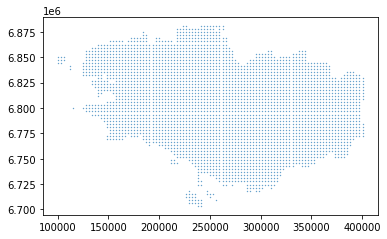

In [15]:
# convert geometryx to centroid
gdf_spot6.set_geometry("centroid",inplace=True)
gdf_spot6.plot(markersize=0.1)

In [16]:
join_spot6_sen2 = gdf_spot6.sjoin(gdf_sen2, how="inner")

In [17]:
join_spot6_sen2.head()

,name,geom_left,geometry,centroid_left,index_right,files,dates,tiles,geom_right,centroid_right
0,ORT_2018_0159_6792_LA93_8Bits.jp2,"POLYGON ((159000 6792000, 159000 6789000, 1620...","POLYGON ((159000.000 6792000.000, 159000.000 6...",POINT (160500.000 6790500.000),70,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180505,T30UVU,"POLYGON ((151254.7952121547 6874638.172445575,...",POINT (210148.2682901771 6815749.698813485)
4,ORT_2018_0255_6843_LA93_8Bits.jp2,"POLYGON ((255000 6843000, 255000 6840000, 2580...","POLYGON ((255000.000 6843000.000, 255000.000 6...",POINT (256500.000 6841500.000),70,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180505,T30UVU,"POLYGON ((151254.7952121547 6874638.172445575,...",POINT (210148.2682901771 6815749.698813485)
5,ORT_2018_0264_6843_LA93_8Bits.jp2,"POLYGON ((264000 6843000, 264000 6840000, 2670...","POLYGON ((264000.000 6843000.000, 264000.000 6...",POINT (265500.000 6841500.000),70,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180505,T30UVU,"POLYGON ((151254.7952121547 6874638.172445575,...",POINT (210148.2682901771 6815749.698813485)
7,ORT_2018_0255_6834_LA93_8Bits.jp2,"POLYGON ((255000 6834000, 255000 6831000, 2580...","POLYGON ((255000.000 6834000.000, 255000.000 6...",POINT (256500.000 6832500.000),70,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180505,T30UVU,"POLYGON ((151254.7952121547 6874638.172445575,...",POINT (210148.2682901771 6815749.698813485)
8,ORT_2018_0225_6873_LA93_8Bits.jp2,"POLYGON ((225000 6873000, 225000 6870000, 2280...","POLYGON ((225000.000 6873000.000, 225000.000 6...",POINT (226500.000 6871500.000),70,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180505,T30UVU,"POLYGON ((151254.7952121547 6874638.172445575,...",POINT (210148.2682901771 6815749.698813485)


In [18]:
join_spot6_sen2 = gpd.GeoDataFrame(join_spot6_sen2, geometry="centroid_left")
join_spot6_sen2.set_crs(epsg=2154,inplace=True)

,name,geom_left,geometry,centroid_left,index_right,files,dates,tiles,geom_right,centroid_right
0,ORT_2018_0159_6792_LA93_8Bits.jp2,"POLYGON ((159000 6792000, 159000 6789000, 1620...","POLYGON ((159000.000 6792000.000, 159000.000 6...",POINT (160500.000 6790500.000),70,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180505,T30UVU,"POLYGON ((151254.7952121547 6874638.172445575,...",POINT (210148.2682901771 6815749.698813485)
4,ORT_2018_0255_6843_LA93_8Bits.jp2,"POLYGON ((255000 6843000, 255000 6840000, 2580...","POLYGON ((255000.000 6843000.000, 255000.000 6...",POINT (256500.000 6841500.000),70,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180505,T30UVU,"POLYGON ((151254.7952121547 6874638.172445575,...",POINT (210148.2682901771 6815749.698813485)
5,ORT_2018_0264_6843_LA93_8Bits.jp2,"POLYGON ((264000 6843000, 264000 6840000, 2670...","POLYGON ((264000.000 6843000.000, 264000.000 6...",POINT (265500.000 6841500.000),70,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180505,T30UVU,"POLYGON ((151254.7952121547 6874638.172445575,...",POINT (210148.2682901771 6815749.698813485)
7,ORT_2018_0255_6834_LA93_8Bits.jp2,"POLYGON ((255000 6834000, 255000 6831000, 2580...","POLYGON ((255000.000 6834000.000, 255000.000 6...",POINT (256500.000 6832500.000),70,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180505,T30UVU,"POLYGON ((151254.7952121547 6874638.172445575,...",POINT (210148.2682901771 6815749.698813485)
8,ORT_2018_0225_6873_LA93_8Bits.jp2,"POLYGON ((225000 6873000, 225000 6870000, 2280...","POLYGON ((225000.000 6873000.000, 225000.000 6...",POINT (226500.000 6871500.000),70,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180505,T30UVU,"POLYGON ((151254.7952121547 6874638.172445575,...",POINT (210148.2682901771 6815749.698813485)
...,...,...,...,...,...,...,...,...,...,...
1051,ORT_2018_0363_6843_LA93_8Bits.jp2,"POLYGON ((363000 6843000, 363000 6840000, 3660...","POLYGON ((363000.000 6843000.000, 363000.000 6...",POINT (364500.000 6841500.000),58,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180708,T30UXV,"POLYGON ((358284.9604004587 6959219.991895379,...",POINT (417267.7453400626 6900242.208039797)
1445,ORT_2018_0363_6846_LA93_8Bits.jp2,"POLYGON ((363000 6846000, 363000 6843000, 3660...","POLYGON ((363000.000 6846000.000, 363000.000 6...",POINT (364500.000 6844500.000),58,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180708,T30UXV,"POLYGON ((358284.9604004587 6959219.991895379,...",POINT (417267.7453400626 6900242.208039797)
1517,ORT_2018_0357_6843_LA93_8Bits.jp2,"POLYGON ((357000 6843000, 357000 6840000, 3600...","POLYGON ((357000.000 6843000.000, 357000.000 6...",POINT (358500.000 6841500.000),58,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180708,T30UXV,"POLYGON ((358284.9604004587 6959219.991895379,...",POINT (417267.7453400626 6900242.208039797)
1758,ORT_2018_0357_6846_LA93_8Bits.jp2,"POLYGON ((357000 6846000, 357000 6843000, 3600...","POLYGON ((357000.000 6846000.000, 357000.000 6...",POINT (358500.000 6844500.000),58,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180708,T30UXV,"POLYGON ((358284.9604004587 6959219.991895379,...",POINT (417267.7453400626 6900242.208039797)


<AxesSubplot:>

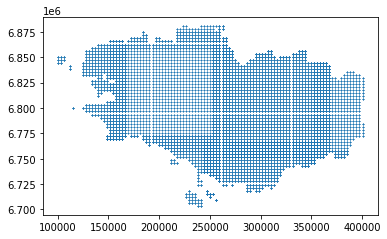

In [19]:
join_spot6_sen2.plot(markersize=0.1)

## Get Spot6 Dates

In [20]:
# Load gdf of date info

In [21]:
path = "/home/simon/CDE_UBS/thesis/data_collection/footprints/other/"
dates_spot6 = gpd.read_file(path+"FRANCE_2018_LA93_INFO.shp")

<AxesSubplot:>

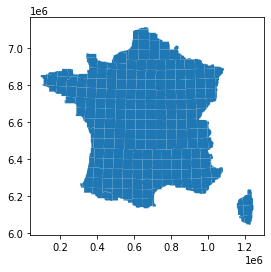

In [22]:
# keep only dare and geometry column
dates_spot6 = dates_spot6[["DATE","geometry"]]
dates_spot6.set_crs(epsg=2154)
dates_spot6.plot()

In [23]:
dates_spot6.head(1)

,DATE,geometry
0,20180630,"POLYGON ((407568.735 6621272.237, 407570.224 6..."


## Join Sen2/Spot6 Dates & Tiles with Spot6 aq. dates

In [24]:
# rop previous remenants
join_spot6_sen2.drop('index_right', inplace=True, axis=1)

In [25]:
# perform inner join and clean up df
join_spot6_sen2_DATES = join_spot6_sen2.sjoin(dates_spot6, how="inner")
join_spot6_sen2_DATES.drop(["geom_right","centroid_right","index_right"], inplace=True, axis=1)

<AxesSubplot:>

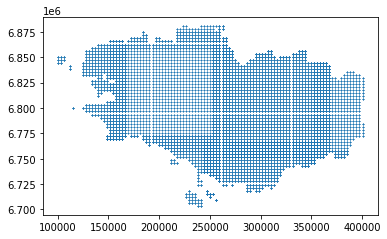

In [26]:
join_spot6_sen2_DATES.plot(markersize=0.1)

In [27]:
# transform back to geometry of footprint
join_spot6_sen2_DATES = gpd.GeoDataFrame(join_spot6_sen2_DATES, geometry="geometry")
join_spot6_sen2_DATES.set_crs(epsg=2154,inplace=True)

,name,geom_left,geometry,centroid_left,files,dates,tiles,DATE
0,ORT_2018_0159_6792_LA93_8Bits.jp2,"POLYGON ((159000 6792000, 159000 6789000, 1620...","POLYGON ((159000.000 6792000.000, 159000.000 6...",POINT (160500.000 6790500.000),/home/simon/CDE_UBS/thesis/data_collection/sen...,20180505,T30UVU,20180622
113,ORT_2018_0156_6789_LA93_8Bits.jp2,"POLYGON ((156000 6789000, 156000 6786000, 1590...","POLYGON ((156000.000 6789000.000, 156000.000 6...",POINT (157500.000 6787500.000),/home/simon/CDE_UBS/thesis/data_collection/sen...,20180505,T30UVU,20180622
115,ORT_2018_0156_6792_LA93_8Bits.jp2,"POLYGON ((156000 6792000, 156000 6789000, 1590...","POLYGON ((156000.000 6792000.000, 156000.000 6...",POINT (157500.000 6790500.000),/home/simon/CDE_UBS/thesis/data_collection/sen...,20180505,T30UVU,20180622
165,ORT_2018_0180_6789_LA93_8Bits.jp2,"POLYGON ((180000 6789000, 180000 6786000, 1830...","POLYGON ((180000.000 6789000.000, 180000.000 6...",POINT (181500.000 6787500.000),/home/simon/CDE_UBS/thesis/data_collection/sen...,20180505,T30UVU,20180622
192,ORT_2018_0159_6795_LA93_8Bits.jp2,"POLYGON ((159000 6795000, 159000 6792000, 1620...","POLYGON ((159000.000 6795000.000, 159000.000 6...",POINT (160500.000 6793500.000),/home/simon/CDE_UBS/thesis/data_collection/sen...,20180505,T30UVU,20180622
...,...,...,...,...,...,...,...,...
1039,ORT_2018_0399_6783_LA93_8Bits.jp2,"POLYGON ((399000 6783000, 399000 6780000, 4020...","POLYGON ((399000.000 6783000.000, 399000.000 6...",POINT (400500.000 6781500.000),/home/simon/CDE_UBS/thesis/data_collection/sen...,20180623,T30UXU,20180420
1629,ORT_2018_0399_6780_LA93_8Bits.jp2,"POLYGON ((399000 6780000, 399000 6777000, 4020...","POLYGON ((399000.000 6780000.000, 399000.000 6...",POINT (400500.000 6778500.000),/home/simon/CDE_UBS/thesis/data_collection/sen...,20180623,T30UXU,20180420
1784,ORT_2018_0396_6780_LA93_8Bits.jp2,"POLYGON ((396000 6780000, 396000 6777000, 3990...","POLYGON ((396000.000 6780000.000, 396000.000 6...",POINT (397500.000 6778500.000),/home/simon/CDE_UBS/thesis/data_collection/sen...,20180623,T30UXU,20180420
2223,ORT_2018_0396_6777_LA93_8Bits.jp2,"POLYGON ((396000 6777000, 396000 6774000, 3990...","POLYGON ((396000.000 6777000.000, 396000.000 6...",POINT (397500.000 6775500.000),/home/simon/CDE_UBS/thesis/data_collection/sen...,20180623,T30UXU,20180420


<AxesSubplot:>

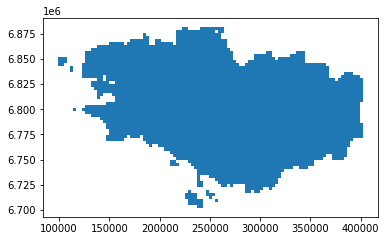

In [28]:
join_spot6_sen2_DATES.plot()

# Find closest date

## Transform dates to proper format

In [29]:
import time
from datetime import datetime

In [30]:
ls_sen2_date = []
ls_spot6_date = []
for date_s2,date_s6 in zip(join_spot6_sen2_DATES["dates"],join_spot6_sen2_DATES["DATE"]):
    ls_sen2_date.append(datetime.strptime(date_s2, "%Y%m%d"))
    ls_spot6_date.append(datetime.strptime(date_s6, "%Y%m%d"))
join_spot6_sen2_DATES["date_sen2"] = ls_sen2_date
join_spot6_sen2_DATES["date_spot6"] = ls_spot6_date
    

In [31]:
join_spot6_sen2_DATES.head(2)

,name,geom_left,geometry,centroid_left,files,dates,tiles,DATE,date_sen2,date_spot6
0,ORT_2018_0159_6792_LA93_8Bits.jp2,"POLYGON ((159000 6792000, 159000 6789000, 1620...","POLYGON ((159000.000 6792000.000, 159000.000 6...",POINT (160500.000 6790500.000),/home/simon/CDE_UBS/thesis/data_collection/sen...,20180505,T30UVU,20180622,2018-05-05,2018-06-22
113,ORT_2018_0156_6789_LA93_8Bits.jp2,"POLYGON ((156000 6789000, 156000 6786000, 1590...","POLYGON ((156000.000 6789000.000, 156000.000 6...",POINT (157500.000 6787500.000),/home/simon/CDE_UBS/thesis/data_collection/sen...,20180505,T30UVU,20180622,2018-05-05,2018-06-22


## Perform check for closest date

In [32]:
spot6_unique = join_spot6_sen2_DATES["name"].unique()
sen2_tiles_unique = join_spot6_sen2_DATES["tiles"].unique()

In [139]:
days_dif = []
days_dif_max = []
spot6_files = []
sen2_dates = []
unique_tile = []
other_acq = []

for spot6_image in spot6_unique:
    tmp = join_spot6_sen2_DATES[join_spot6_sen2_DATES["name"] == spot6_image]
    
    # extract dates for this specific Spot6 Aquisition
    spot6_file = 0
    spot6_date = list(tmp["date_spot6"])[0]
    sen2_dates = list(tmp["date_sen2"])
    
    # get sen2 file names and clean
    sen2_files = list(tmp["files"])
    for v,i in enumerate(sen2_files):
        sen2_files[v] = i[i.rfind("/")+1:]

    # Compare for closest point in time
    min_dif = 999999
    max_dif = 0
    s2_min_date = 0
    for s2_date in sen2_dates:
        dif = abs((spot6_date-s2_date).days)
        
        if max_dif<dif:
            max_dif = dif
        
        if min_dif>dif:
            min_dif=dif
            s2_min_date = s2_date
    
    # append dict of next closest sen2 aq. dates
    dates_dict = {}
    for s2_date,s2_file in zip(sen2_dates,sen2_files):
        dif = abs((spot6_date-s2_date).days)
        dates_dict[dif] = [s2_date,s2_file]
    other_acq.append(dates_dict)
            
    days_dif.append(min_dif)
    days_dif_max.append(max_dif)
    sen2_dates.append(s2_min_date)
    unique_tile.append(spot6_image)

### Test to build indepentent gdf (works!)

In [140]:
df_new = pd.DataFrame(list(zip(unique_tile, days_dif,days_dif_max,other_acq)),columns =['name', 'min','max','other_acq'])
df_new = gpd.GeoDataFrame(df_new)

# 2
df_extract = pd.DataFrame(list(zip(gdf_spot6["name"],gdf_spot6["geom"])),columns =['name', 'geom'])
df_extract = gpd.GeoDataFrame(df_extract, geometry="geom")
df_extract.set_crs(epsg=2154,inplace=True)


,name,geom
0,ORT_2018_0159_6792_LA93_8Bits.jp2,"POLYGON ((159000.000 6792000.000, 159000.000 6..."
1,ORT_2018_0147_6846_LA93_8Bits.jp2,"POLYGON ((147000.000 6846000.000, 147000.000 6..."
2,ORT_2018_0279_6834_LA93_8Bits.jp2,"POLYGON ((279000.000 6834000.000, 279000.000 6..."
3,ORT_2018_0342_6771_LA93_8Bits.jp2,"POLYGON ((342000.000 6771000.000, 342000.000 6..."
4,ORT_2018_0255_6843_LA93_8Bits.jp2,"POLYGON ((255000.000 6843000.000, 255000.000 6..."
...,...,...
3347,ORT_2018_0219_6849_LA93_8Bits.jp2,"POLYGON ((219000.000 6849000.000, 219000.000 6..."
3348,ORT_2018_0363_6780_LA93_8Bits.jp2,"POLYGON ((363000.000 6780000.000, 363000.000 6..."
3349,ORT_2018_0312_6735_LA93_8Bits.jp2,"POLYGON ((312000.000 6735000.000, 312000.000 6..."
3350,ORT_2018_0288_6801_LA93_8Bits.jp2,"POLYGON ((288000.000 6801000.000, 288000.000 6..."


In [141]:
df_new = df_new.merge(df_extract,on="name", how="inner")
df_new = gpd.GeoDataFrame(df_new)
df_new = gpd.GeoDataFrame(df_new, geometry="geom")
df_new.set_crs(epsg=2154,inplace=True)

,name,min,max,other_acq,geom
0,ORT_2018_0159_6792_LA93_8Bits.jp2,0,97,"{48: [2018-05-05 00:00:00, 'SENTINEL2B_2018050...","POLYGON ((159000.000 6792000.000, 159000.000 6..."
1,ORT_2018_0156_6789_LA93_8Bits.jp2,0,97,"{48: [2018-05-05 00:00:00, 'SENTINEL2B_2018050...","POLYGON ((156000.000 6789000.000, 156000.000 6..."
2,ORT_2018_0156_6792_LA93_8Bits.jp2,0,97,"{48: [2018-05-05 00:00:00, 'SENTINEL2B_2018050...","POLYGON ((156000.000 6792000.000, 156000.000 6..."
3,ORT_2018_0180_6789_LA93_8Bits.jp2,4,97,"{48: [2018-05-05 00:00:00, 'SENTINEL2B_2018050...","POLYGON ((180000.000 6789000.000, 180000.000 6..."
4,ORT_2018_0159_6795_LA93_8Bits.jp2,0,97,"{48: [2018-05-05 00:00:00, 'SENTINEL2B_2018050...","POLYGON ((159000.000 6795000.000, 159000.000 6..."
...,...,...,...,...,...
3347,ORT_2018_0399_6783_LA93_8Bits.jp2,1,159,"{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...","POLYGON ((399000.000 6783000.000, 399000.000 6..."
3348,ORT_2018_0399_6780_LA93_8Bits.jp2,1,159,"{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...","POLYGON ((399000.000 6780000.000, 399000.000 6..."
3349,ORT_2018_0396_6780_LA93_8Bits.jp2,1,159,"{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...","POLYGON ((396000.000 6780000.000, 396000.000 6..."
3350,ORT_2018_0396_6777_LA93_8Bits.jp2,1,159,"{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...","POLYGON ((396000.000 6777000.000, 396000.000 6..."


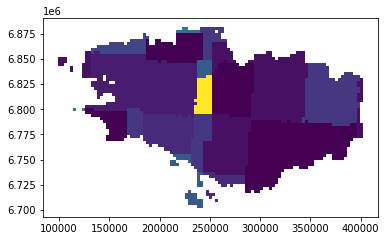

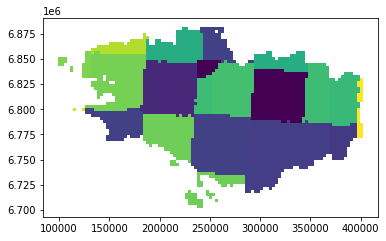

In [162]:
df_new.plot(column='min')
df_new.plot(column='max')
plt.show()

In [147]:
#df_new.to_file("/home/simon/CDE_UBS/thesis/data_collection/sen2/"+"closest_dates.geojson", driver="GeoJSON")
#df_new.to_file("closest_dates.gpkg", driver="GPKG")
df_new.to_pickle("/home/simon/CDE_UBS/thesis/data_collection/sen2/closest_dates.pkl")

In [153]:
df_new

,name,min,max,other_acq,geom
0,ORT_2018_0159_6792_LA93_8Bits.jp2,0,97,"{48: [2018-05-05 00:00:00, 'SENTINEL2B_2018050...","POLYGON ((159000.000 6792000.000, 159000.000 6..."
1,ORT_2018_0156_6789_LA93_8Bits.jp2,0,97,"{48: [2018-05-05 00:00:00, 'SENTINEL2B_2018050...","POLYGON ((156000.000 6789000.000, 156000.000 6..."
2,ORT_2018_0156_6792_LA93_8Bits.jp2,0,97,"{48: [2018-05-05 00:00:00, 'SENTINEL2B_2018050...","POLYGON ((156000.000 6792000.000, 156000.000 6..."
3,ORT_2018_0180_6789_LA93_8Bits.jp2,4,97,"{48: [2018-05-05 00:00:00, 'SENTINEL2B_2018050...","POLYGON ((180000.000 6789000.000, 180000.000 6..."
4,ORT_2018_0159_6795_LA93_8Bits.jp2,0,97,"{48: [2018-05-05 00:00:00, 'SENTINEL2B_2018050...","POLYGON ((159000.000 6795000.000, 159000.000 6..."
...,...,...,...,...,...
3347,ORT_2018_0399_6783_LA93_8Bits.jp2,1,159,"{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...","POLYGON ((399000.000 6783000.000, 399000.000 6..."
3348,ORT_2018_0399_6780_LA93_8Bits.jp2,1,159,"{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...","POLYGON ((399000.000 6780000.000, 399000.000 6..."
3349,ORT_2018_0396_6780_LA93_8Bits.jp2,1,159,"{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...","POLYGON ((396000.000 6780000.000, 396000.000 6..."
3350,ORT_2018_0396_6777_LA93_8Bits.jp2,1,159,"{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...","POLYGON ((396000.000 6777000.000, 396000.000 6..."


In [164]:
pwd

'/home/simon/CDE_UBS/thesis/data_collection'